In [5]:
import json

from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [6]:
def xiongetal(df, vars, dep_var):
    y = df[dep_var]

    r2_old = 0
    r2_best = 0
    r2_inc = 0.01

    left = vars[:]
    selected = []


    while True:
        for m in left:
            metrics = selected + [m]
            X = df[metrics]
            y_pred = cross_val_predict(LinearRegression(), X, y, cv=10)
            r2_new = r2_score(y, y_pred)
            if r2_new > r2_best:
                r2_best = r2_new
                m_best = m
        if r2_best - r2_old > r2_inc:
            selected.append(m_best)
            left.remove(m_best)
            r2_old = r2_best
        else:
            break

    return selected

In [11]:
def evaluate(casestudy):
    datapath = '../datasets/{}/workload'.format(casestudy)
    exp = pd.read_csv(datapath + '/experiments.csv', header=None, delimiter=';')
    from_, to = exp.iloc[0, [1, 2]]

    with open('../results/{}/workload.json'.format(casestudy)) as f:
        delag_res = json.load(f)
    
    rpc_scope_res = []
        
    for frontend in delag_res.keys():
        path = "{}/{}__{}_{}.parquet".format(datapath, frontend, from_, to)
        print("Request class:", frontend)
        df = pd.read_parquet(path)
        rpcs =  [c for c in df.columns if c!="traceId" and c!="experiment" and  c!=frontend]
        res = xiongetal(df, rpcs, frontend)
        rpc_scope_res.append(len(res)/len(rpcs))
        for rpc in res:
            r, _ = pearsonr(df[rpc], df[frontend])
            print("Pearson r of RPC {}: {} ".format(rpc, r))            
            sns.scatterplot(data=df, x=rpc, y=frontend)
            plt.show()
        delag_rpcs = {rpc for pat in delag_res[frontend] for rpc, _, _ in pat}
        print("Intersection with DeLag", delag_rpcs & set(res))
        print('\n' + '-'*60 + '\n')
        
    return rpc_scope_res


Request class: ts-travel-service_queryInfo
Pearson r of RPC ts-seat-service_getLeftTicketOfInterval: 0.9817562235974514 


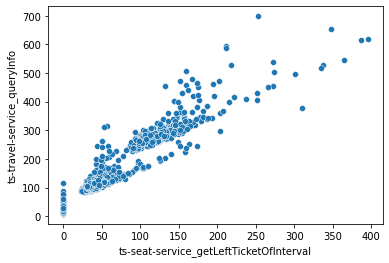

Pearson r of RPC ts-ticketinfo-service_queryForTravel: 0.9640096287904786 


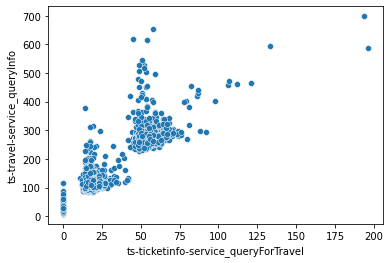

Intersection with DeLag {'ts-ticketinfo-service_queryForTravel'}

------------------------------------------------------------

Request class: ts-travel-plan-service_getByCheapest
Pearson r of RPC ts-route-plan-service_getCheapestRoutes: 0.9951272993457959 


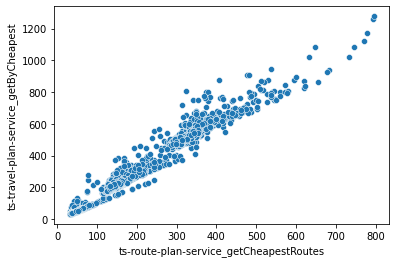

Intersection with DeLag set()

------------------------------------------------------------

Request class: ts-preserve-service_preserve
Pearson r of RPC ts-travel-service_getTripAllDetailInfo: 0.9837690389595984 


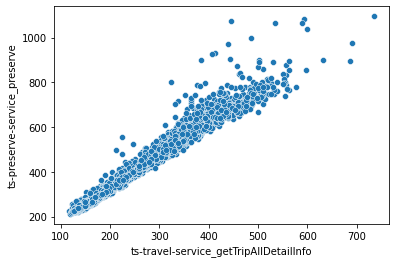

Pearson r of RPC ts-seat-service_create: 0.9390339462295274 


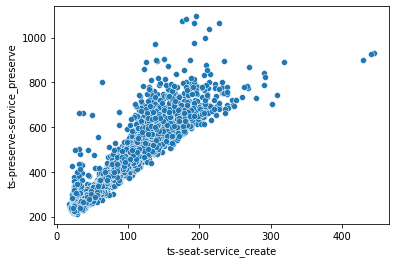

Intersection with DeLag {'ts-travel-service_getTripAllDetailInfo'}

------------------------------------------------------------

Request class: ts-travel-service_queryInfo
Pearson r of RPC ts-seat-service_getLeftTicketOfInterval: 0.9817562235974514 


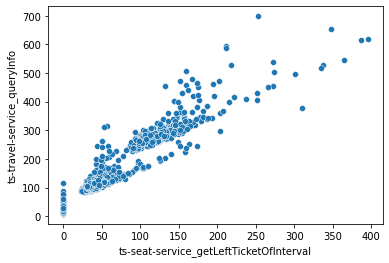

Pearson r of RPC ts-ticketinfo-service_queryForTravel: 0.9640096287904786 


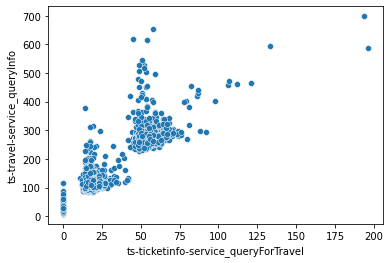

Intersection with DeLag {'ts-ticketinfo-service_queryForTravel'}

------------------------------------------------------------

Request class: ts-travel-plan-service_getByCheapest
Pearson r of RPC ts-route-plan-service_getCheapestRoutes: 0.9951272993457959 


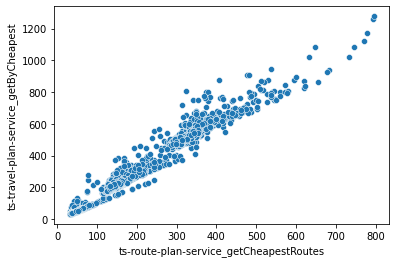

Intersection with DeLag set()

------------------------------------------------------------

Request class: ts-preserve-service_preserve
Pearson r of RPC ts-travel-service_getTripAllDetailInfo: 0.9837690389595984 


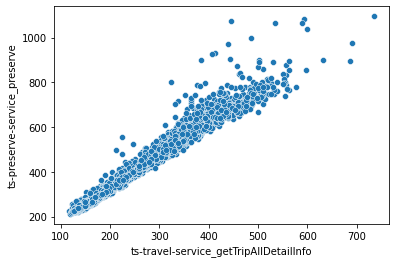

Pearson r of RPC ts-seat-service_create: 0.9390339462295274 


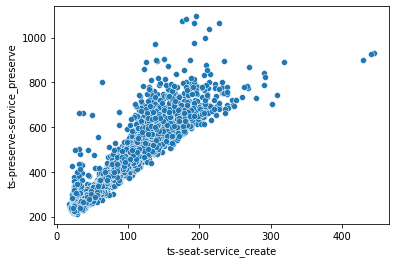

Intersection with DeLag {'ts-travel-service_getTripAllDetailInfo'}

------------------------------------------------------------

Request class: HomeControllerHome
Pearson r of RPC get: 0.5615141909729326 


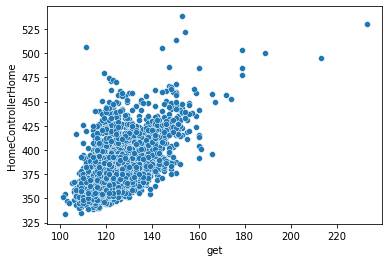

Pearson r of RPC CategoriesControllerGetcategory: 0.2932958543409696 


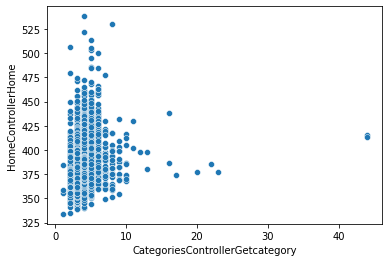

Intersection with DeLag {'get'}

------------------------------------------------------------

Request class: HomeControllerHome
Pearson r of RPC get: 0.5615141909729326 


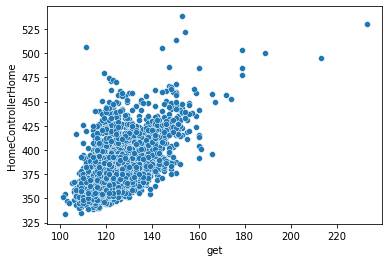

Pearson r of RPC CategoriesControllerGetcategory: 0.2932958543409696 


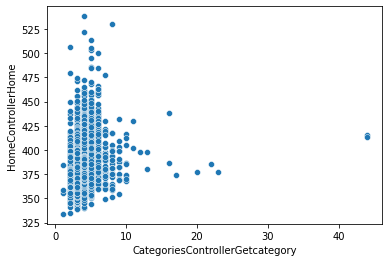

Intersection with DeLag {'get'}

------------------------------------------------------------



In [12]:
rpc_scope_res = []
for cs in ['trainticket', 'eshopper']:
    rpc_scope_res +=  evaluate(cs)
    evaluate(cs)

In [13]:
print("Mean RPC reduction provided by XLR {:.1%}".format(np.mean(rpc_scope_res)))

Mean RPC reduction provided by XLR 14.3%%
